pt_sale
0    570713
1    102181
Name: count, dtype: int64


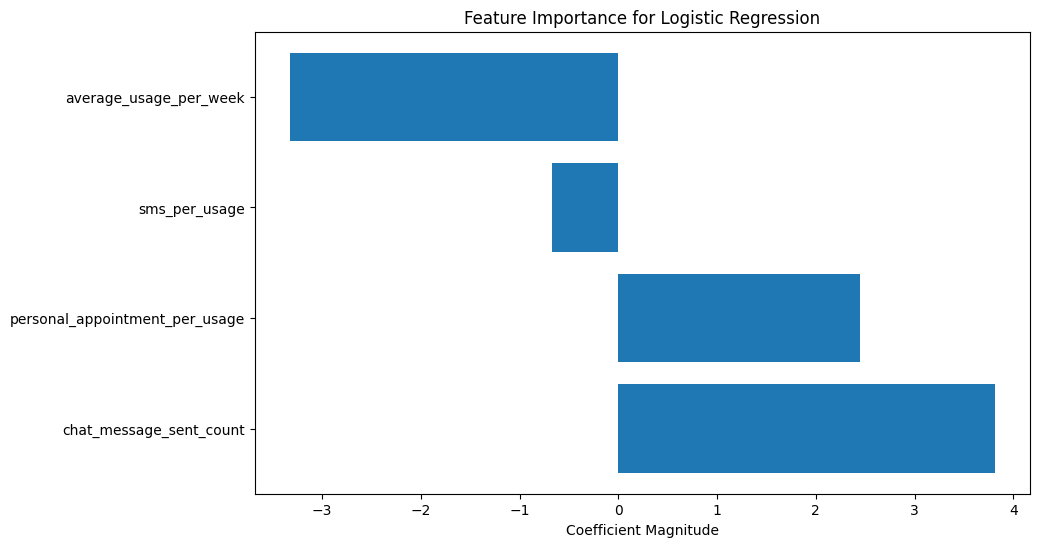

              precision    recall  f1-score   support

           0       0.73      0.16      0.26     39385
           1       0.30      0.86      0.45     16779

    accuracy                           0.37     56164
   macro avg       0.52      0.51      0.35     56164
weighted avg       0.60      0.37      0.32     56164



C:\Users\Amit\AppData\Local\Temp\ipykernel_13476\2853257115.py:276: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_positives = sum(y_true[i] for i in top_predictions)
C:\Users\Amit\AppData\Local\Temp\ipykernel_13476\2853257115.py:300: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_positives = sum(y_true[i] for i in top_predictions)


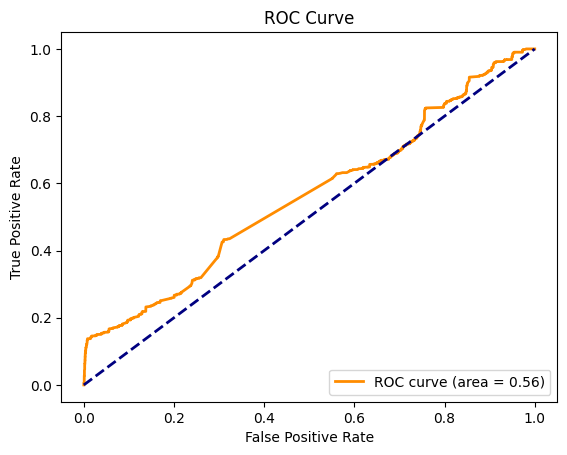

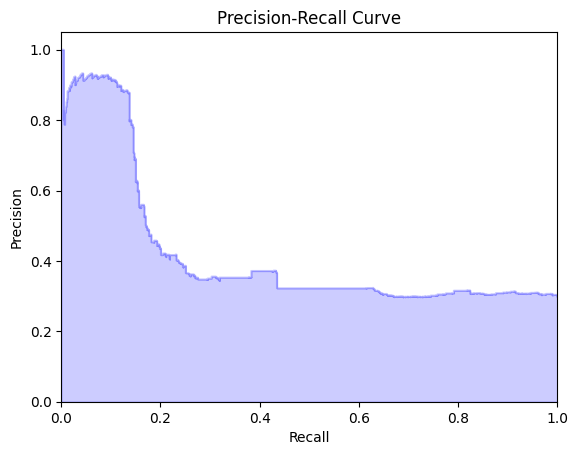

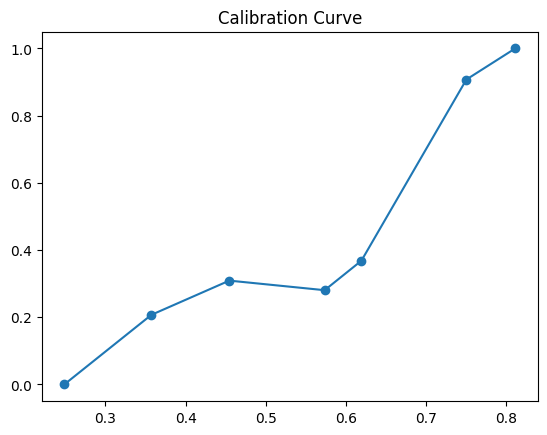

c:\Users\Amit\Vi\Vi\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


------------------------
model: LogisticRegression(C=0.01, class_weight='balanced')
------------------------
accuracy: 0.36852788262944236
------------------------
precision: 0.3041400272508123
------------------------
recall: 0.864711842183682
------------------------
f1: 0.4500031015445692
------------------------
roc_auc: 0.5606920479492405
------------------------
precision@k: 1.0
------------------------
recall@k: 0.0005959830740806961


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import MinMaxScaler

def load_and_preprocess_data():
    """
    Load events and subscribers data, drop unnecessary columns, and handle missing values.

    Returns:
    events_data (pd.DataFrame): DataFrame containing events data.
    subscribers_data (pd.DataFrame): DataFrame containing subscribers data.
    """
    events_data = pd.read_csv('data/events_data.csv')
    subscribers_data = pd.read_csv('data/subscribers_data.csv')

    # Handle missing values
    events_data.fillna(0, inplace=True)
    subscribers_data.fillna(0, inplace=True)

    # Convert date fields to datetime format
    events_data['dt'] = pd.to_datetime(events_data['dt'])
    subscribers_data['effective_date'] = pd.to_datetime(subscribers_data['effective_date'])

    # Sort data by date
    events_data.sort_values(by='dt', inplace=True)
    subscribers_data.sort_values(by='effective_date', inplace=True)

    # Merge data
    # Step 1: Drop rows not in subscribers_data
    events_data = events_data[events_data['member_id'].isin(subscribers_data['member_id'])]

    # Step 2: Keep only unique rows in subscribers_data
    unique_subscribers_data = subscribers_data.drop_duplicates(subset='member_id')

    # Step 3: Merge data to add 'gender', 'city', and 'age' columns
    merged_data = pd.merge(events_data, unique_subscribers_data[['member_id', 'gender', 'city', 'age', 'effective_date']], on='member_id', how='left')

    # Calculate age from effective_date to dt
    merged_data['age'] = merged_data['age'] - ((merged_data['effective_date'] - merged_data['dt']).dt.days // 365)

    default_age_value = 0
    merged_data['age'] = merged_data['age'].apply(lambda x: x if x >= 0 else default_age_value)

    merged_data.drop(columns=['effective_date'], inplace=True)

    # Save to new csv
    # merged_data.to_csv('updated_events_data.csv', index=False)

    return merged_data, subscribers_data

def filter_events_by_date(events_data, specific_date, duration):
    """
    Filter events data based on a specific date and duration.

    Args:
    events_data (pd.DataFrame): DataFrame containing events data.
    specific_date (datetime): Specific date for filtering.
    duration (timedelta): Duration for filtering.

    Returns:
    filtered_df (pd.DataFrame): Filtered DataFrame.
    unique_members_in_week (numpy.ndarray): Unique member IDs in the specified week.
    """

    week_start = specific_date
    week_end = week_start + timedelta(days=7)
    members_in_week = events_data[(events_data['dt'] >= week_start) & (events_data['dt'] <= week_end)]['member_id']
    filtered_df_backward = events_data[(events_data['dt'] >= (specific_date - duration)) & (events_data['dt'] < (week_start)) & (events_data['member_id'].isin(members_in_week))]
    filtered_df_forward = events_data[(events_data['dt'] >= week_start) & (events_data['dt'] < week_end+timedelta(days=7)) & (events_data['member_id'].isin(members_in_week))]

    return filtered_df_backward, filtered_df_forward, members_in_week

def create_result_df(filtered_df, filtered_df_forward, unique_members):
    """
    Create a DataFrame with event type counts for each member (create features).

    Args:
    filtered_df (pd.DataFrame): Filtered DataFrame.
    unique_members (numpy.ndarray): Unique member IDs. (week forward)
    event_types (list): List of event types.

    Returns:
    result_df (pd.DataFrame): DataFrame with event type counts.
    """
    result_df = pd.DataFrame(index=unique_members)
    event_types = ['personal_appointment_scheduled', 'sms_sent', 'chat_message_sent', 'usage']


    for event_type in event_types:
        event_count = filtered_df[filtered_df['event_type'] == event_type].groupby('member_id').size()
        result_df[f'{event_type}_count'] = result_df.index.map(event_count).fillna(0)

    result_df['average_usage_per_week'] = (result_df['usage_count'] / 12).astype(int)
    
    # Calculate sms_per_usage, handling zero in 'sms_sent_count'
    result_df['sms_per_usage'] = (
        result_df['usage_count'] / result_df['sms_sent_count'].replace({0: np.nan})
    ).fillna(0).astype(int)

    # Calculate personal_appointment_per_usage, handling zero in 'personal_appointment_scheduled_count'
    result_df['personal_appointment_per_usage'] = (
        result_df['usage_count'] / result_df['personal_appointment_scheduled_count'].replace({0: np.nan})
    ).fillna(0).astype(int)

    result_df.drop(columns=['usage_count'], inplace=True)
    result_df.drop(columns=['sms_sent_count'], inplace=True)
    result_df.drop(columns=['personal_appointment_scheduled_count'], inplace=True)
    
    # Aggregate 'gender' and 'age' columns
    aggregated_info = filtered_df.groupby('member_id').agg({'gender': 'first', 'age': 'first'})

    # Map 'gender' to numerical values (1 for 'male', 2 for 'female', 0 for 'unknown')
    gender_mapping = {'M': 1, 'F': 2, 'unknown': 0}
    aggregated_info['gender'] = aggregated_info['gender'].map(gender_mapping)

    result_df = result_df.join(aggregated_info, how='left').fillna(0)

    result_df.drop(columns=['age'], inplace=True)
    result_df.drop(columns=['gender'], inplace=True)

    # Calculate if a member had a pt_sale event in the last month or in the next 2 week (1 for yes, 0 for no)
    pt_sale_count = filtered_df_forward[filtered_df_forward['event_type'] == 'pt_sale'].groupby('member_id').size()
    pt_sale_count_before = filtered_df[filtered_df['event_type'] == 'pt_sale'].groupby('member_id').size()

    result_df['pt_sale'] = ((result_df.index.map(pt_sale_count).fillna(0) > 0) | (result_df.index.map(pt_sale_count_before).fillna(0) > 0)).astype(int)

    return result_df

def train_and_evaluate_model_logistic_regression(result_df):
    """
    Train a logistic regression model and evaluate its performance.

    Args:
    result_df (pd.DataFrame): DataFrame with event type counts.

    Returns:
    model: Trained logistic regression model.
    """

    X = result_df.drop(columns=['pt_sale'])
    y = result_df['pt_sale']

    # Manually split based on member IDs
    ids = result_df.index.unique()
    split = int(0.8 * len(ids))
    train_ids, test_ids = ids[:split], ids[split:]

    # Use boolean indexing to get training and testing sets
    train_mask = result_df.index.isin(train_ids)
    test_mask = result_df.index.isin(test_ids)

    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

    # Normalized params:
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    # Choose a classification algorithm (Logistic Regression)
    model = LogisticRegression(class_weight = 'balanced', C=0.01)

    # Train the model
    model.fit(X_train_normalized, y_train)
    plot_feature_importance(model, X.columns)

    # Make predictions on the testing set
    y_pred = model.predict(X_test_normalized)

    # Evaluate the model
    print(classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_normalized)[:, 1])
    # Calculate precision@k and recall@k
    k = 10
    precision_at_k_val = precision_at_k(y_test, model.predict_proba(X_test_normalized)[:, 1], k)
    recall_at_k_val = recall_at_k(y_test, model.predict_proba(X_test_normalized)[:, 1], k)


    # Plot diagnostic curves
    plot_diagnostic_curves(model, X_test_normalized, y_test)

    return model, accuracy, precision, recall, f1, roc_auc, precision_at_k_val, recall_at_k_val

def train_and_evaluate_random_forest(result_df):
    """
    Train a random forest model and evaluate its performance.

    Args:
    result_df (pd.DataFrame): DataFrame with event type counts.

    Returns:
    model: Trained random forest model.
    accuracy, precision, recall, f1: Evaluation metrics.
    """
    X = result_df.drop(columns=['pt_sale'])
    y = result_df['pt_sale']

    # Manually split based on member IDs
    ids = result_df.index.unique()
    split = int(0.8 * len(ids))
    train_ids, test_ids = ids[:split], ids[split:]

    # Use boolean indexing to get training and testing sets
    train_mask = result_df.index.isin(train_ids)
    test_mask = result_df.index.isin(test_ids)

    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

    # Choose a classification algorithm (Random Forest)
    model = RandomForestClassifier(class_weight='balanced_subsample', random_state=15)

    # Train the model
    model.fit(X_train, y_train)
    plot_feature_importance_random_forest(model, X.columns)

    # Make predictions on the testing set
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    # Calculate precision@k and recall@k
    k = 10
    precision_at_k_val = precision_at_k(y_test, model.predict_proba(X_test)[:, 1], k)
    recall_at_k_val = recall_at_k(y_test, model.predict_proba(X_test)[:, 1], k)

    # Plot diagnostic curves
    plot_diagnostic_curves(model, X_test, y_test)

    return model, accuracy, precision, recall, f1, roc_auc, precision_at_k_val, recall_at_k_val

def precision_at_k(y_true, y_scores, k=10):
    """
    Calculate precision at k.

    Args:
    y_true (array-like): True labels (1 for positive, 0 for negative).
    y_scores (array-like): Predicted probabilities or scores.
    k (int): Number of top predictions to consider.

    Returns:
    precision (float): Precision at k.
    """
    # Sort predictions in descending order
    sorted_indices = sorted(range(len(y_scores)), key=lambda i: y_scores[i], reverse=True)

    # Select top k predictions
    top_predictions = sorted_indices[:k]

    # Calculate precision at k
    true_positives = sum(y_true[i] for i in top_predictions)
    precision = true_positives / k if k > 0 else 0.0

    return precision

def recall_at_k(y_true, y_scores, k=10):
    """
    Calculate recall at k.

    Args:
    y_true (array-like): True labels (1 for positive, 0 for negative).
    y_scores (array-like): Predicted probabilities or scores.
    k (int): Number of top predictions to consider.

    Returns:
    recall (float): Recall at k.
    """
    # Sort predictions in descending order
    sorted_indices = sorted(range(len(y_scores)), key=lambda i: y_scores[i], reverse=True)

    # Select top k predictions
    top_predictions = sorted_indices[:k]

    # Calculate recall at k
    true_positives = sum(y_true[i] for i in top_predictions)
    total_positives = sum(y_true)
    recall = true_positives / total_positives if total_positives > 0 else 0.0

    return recall

def make_predictions(model, result_df_new, subscribers_data_new, date_to_predict):
    """
    Make predictions for all individuals who have not taken personal training and have a subscription.

    Args:
    model: Trained logistic regression model.
    result_df (pd.DataFrame): DataFrame with event type counts.
    subscribers_data (pd.DataFrame): DataFrame containing subscribers data.
    date_to_predict (datetime): Specific date for predictions.

    Returns:
    subscribers_data_for_date (pd.DataFrame): Subscribers data with predicted probabilities.
    """
    prediction_df = result_df_new[result_df_new['pt_sale'] == 0].drop(columns=['pt_sale'])
    subscribers_data_for_date = subscribers_data_new[subscribers_data_new['effective_date'] == date_to_predict]

    # Filter prediction_df to include only rows with member_id present in subscribers_data_for_date
    # prediction_df = prediction_df[prediction_df.index.isin(subscribers_data_for_date['member_id'])]

    if not prediction_df.empty:
        # Continue with the predictions
        prediction_df['predicted_probability'] = model.predict_proba(prediction_df)[:, 1]

        # Rank and recommend the top 10 individuals
        top_10_recommendations = prediction_df.sort_values(by='predicted_probability', ascending=False).drop_duplicates().head(10)

    else:
        print("No predictions available for the selected date.")

    # Merge the DataFrames on 'member_id' to add 'predicted_probability' to 'subscribers_data_for_date'
    subscribers_data_for_date = subscribers_data_for_date.merge(prediction_df[['predicted_probability']],
                                                                left_on='member_id', right_index=True, how='left')

    # Fill NaN values with None
    subscribers_data_for_date['predicted_probability'] = subscribers_data_for_date['predicted_probability'].where(
        subscribers_data_for_date['predicted_probability'].notna(), None)

    return subscribers_data_for_date, top_10_recommendations[['predicted_probability']]

def generate_top_10_by_segment(subscribers_data_for_date):
    """
    Generate and print top 10 recommendations for each segment.

    Args:
    subscribers_data_for_date (pd.DataFrame): Subscribers data with predicted probabilities.

    Returns:
    None
    """
    sorted_dataframe = subscribers_data_for_date.sort_values(by='predicted_probability', ascending=False)
    top_10_by_segment = {}

    for segment_code in sorted_dataframe['segment_code'].unique():
        # Filter the DataFrame for the current segment_code and select the top 10 rows
        top_10_for_segment = sorted_dataframe[
            (sorted_dataframe['segment_code'] == segment_code) &
            (sorted_dataframe['predicted_probability'].notna()) &
            (sorted_dataframe['predicted_probability'] > 0.1)
        ].drop_duplicates(subset=['member_id']).head(10)

        # Store only the 'member_id' and 'predicted_probability' columns in the dictionary
        top_10_by_segment[segment_code] = top_10_for_segment[['member_id', 'predicted_probability']]


    # Print the top 10 members for each segment
    for segment_code, top_10_for_segment in top_10_by_segment.items():
        print(f"Top 10 for segment {segment_code}:\n{top_10_for_segment}\n")

def check_success(member_id, date_to_predict, events_data):
    """
    Check if a member has a "pt_sale" event in a week from the specific date.

    Args:
    member_id (int): Member ID to check.
    specific_date (datetime): Specific date.
    events_data (pd.DataFrame): DataFrame containing events data.

    Returns:
    success (bool): True if success, False otherwise.
    """
    end_date = date_to_predict + timedelta(days=14)  # 2 weeks from the specific date
    member_events = events_data[(events_data['member_id'] == member_id) & (events_data['event_type'] == 'pt_sale')]
    success = any((member_events['dt'] >= date_to_predict) & (member_events['dt'] <= end_date))

    return success

def collect_results(events_data, subscribers_data, start_date_for_train, date_to_predict, duration_in_days = 90, weeks_to_train = 50, model_type=1):
    """
    Train and evaluate a predictive model to identify potential customers for a specific date.

    Args:
        events_data (pd.DataFrame): DataFrame containing events data, including member_id, event_type, and dt (date).
        subscribers_data (pd.DataFrame): DataFrame containing subscribers' data, including member_id and additional features.
        start_date_for_train (datetime): The starting date for training the model.
        date_to_predict (datetime): The specific date for which predictions are generated.
        duration_in_days (int, optional): The duration of the training period in days. Defaults to 90.
        weeks_to_train (int, optional): The number of weeks to train the model. Defaults to 50.
        model_type (int, optional): Model type selection (1 for logistic regression, 2 for random forest). Defaults to 1.

    Returns:
        results (dict): A dictionary containing model evaluation metrics.
            - 'model': Trained model.
            - 'accuracy': Accuracy of the model on the test set.
            - 'precision': Precision of the model on the test set.
            - 'recall': Recall of the model on the test set.
            - 'f1': F1 score of the model on the test set.
            - 'roc_auc': Area under the ROC curve.
            - 'precision@k': Precision at top-k members.
            - 'recall@k': Recall at top-k members.

        model (object): Trained machine learning model.

    """

    combine_result_dt = []
    for i in range(weeks_to_train): # all relevnt dates in events_data 
        date_to_collect = start_date_for_train + timedelta(days=6*i)
        filtered_df, filtered_df_forward, unique_members_in_week = filter_events_by_date(events_data, date_to_collect, timedelta(days=duration_in_days))
        result_df = create_result_df(filtered_df, filtered_df_forward, unique_members_in_week)
        combine_result_dt.append(result_df)

    combine_result_dt = pd.concat(combine_result_dt)
    print(combine_result_dt['pt_sale'].value_counts())
    
    # Check for features that are always zero
    zero_features = combine_result_dt.columns[combine_result_dt.sum() == 0]

    # Print the zero features
    if len(zero_features) > 0:
        print("Features that always have a value of zero:")
        print(zero_features)
        combine_result_dt = combine_result_dt.drop(columns=zero_features)
    
    if model_type==1:
        model, accuracy, precision, recall, f1, roc_auc, precision_at_k, recall_at_k = train_and_evaluate_model_logistic_regression(combine_result_dt)
    else:
        model, accuracy, precision, recall, f1, roc_auc, precision_at_k, recall_at_k = train_and_evaluate_random_forest(combine_result_dt)

    combine_result_dt_new = []
    for i in range(4): 
        date_to_collect = date_to_predict + timedelta(days=6*i)
        filtered_df_new, filtered_df_forward_new, unique_members_in_week_new = filter_events_by_date(events_data, date_to_collect, timedelta(days=duration_in_days))
        result_df_new = create_result_df(filtered_df_new, filtered_df_forward_new, unique_members_in_week_new)
        combine_result_dt_new.append(result_df_new)
    combine_result_dt_new = pd.concat(combine_result_dt_new)

    subscribers_data_for_date, top_10_predictions = make_predictions(model, combine_result_dt_new, subscribers_data, date_to_predict)

    generate_top_10_by_segment(subscribers_data_for_date)

    top_10_predictions['success'] = False
    # Check success for each member in top 10 predictions
    for idx in top_10_predictions.index:
        top_10_predictions.loc[idx, 'success'] = check_success(idx, date_to_predict, events_data)

    # print(top_10_predictions)
    
    results = {
    'model': model,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'precision@k': precision_at_k ,
    'recall@k': recall_at_k,
    }

    return results, model

def plot_feature_importance(model, feature_names):
    """
    Plot feature importance for a logistic regression model.

    Args:
    model: Trained logistic regression model.
    feature_names (list): List of feature names.

    Returns:
    None
    """
    if not hasattr(model, 'coef_'):
        print("Feature importances are not available for this model.")
        return

    importances = model.coef_[0]
    feature_importance = pd.DataFrame(list(zip(feature_names, importances)), columns=['Feature', 'Importance'])
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Coefficient Magnitude')
    plt.title('Feature Importance for Logistic Regression')
    plt.show()

def plot_feature_importance_random_forest(model, feature_names):
    """
    Plot feature importance for a random forest model.

    Args:
    model: Trained random forest model.
    feature_names (list): List of feature names.

    Returns:
    None
    """
    if not hasattr(model, 'feature_importances_'):
        print("Feature importances are not available for this model.")
        return

    importances = model.feature_importances_
    feature_importance = pd.DataFrame(list(zip(feature_names, importances)), columns=['Feature', 'Importance'])
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance for Random Forest')
    plt.show()

def plot_diagnostic_curves(model, X_test, y_test):
    """
    Plot diagnostic curves for a classification model.

    Args:
    model: Trained classification model.
    X_test (pd.DataFrame): Test set features.
    y_test (pd.Series): Test set labels.

    Returns:
    None
    """
    # Plot ROC curve
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Plot precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_scores)

    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()

    # Calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_scores, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o')
    plt.title('Calibration Curve')
    plt.show()

if __name__ == "__main__":
    start_date_for_train = datetime(2019, 6, 1) # start of relevant data to train
    end_date_for_train = datetime(2021, 8, 21) # end of relevant data to train
    # Calculate the difference between end_date_for_train and start_date_for_train
    number_of_weeks = (end_date_for_train - start_date_for_train).days // 7

    date_to_predict = datetime(2021, 1, 1) 
    events_data, subscribers_data = load_and_preprocess_data()
    
    results, model = collect_results(events_data, subscribers_data, start_date_for_train, date_to_predict, duration_in_days = 90, weeks_to_train = number_of_weeks, model_type=1)

    for key, value in results.items():
        print("------------------------")
        print(f"{key}: {value}")
